In [1]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import seaborn as sns
import glob
import os
import random
from tqdm import tqdm
from scipy import stats
import networkx as nx

In [2]:
from torchvision.io import read_image
import torchvision.transforms as T

In [3]:
%load_ext autoreload
%autoreload 2

---

In [4]:
DATA_DIR = '/data/ltorres'

In [5]:
torch.manual_seed(7)
np.random.seed(7)
random.seed(7)

In [6]:
def get_matrix_density(tensor):
    with torch.no_grad():
        density = tensor.sum().item()/(tensor.flatten().shape[0])
    return density

---

In [7]:
def get_paths(data_dir, dataset_type):
    return glob.glob(
                     os.path.join(data_dir,f'GCD/{dataset_type}/**/*.jpg'), 
                     recursive=True
                    )

In [8]:
train_paths = get_paths(DATA_DIR, "train")

In [9]:
random.shuffle(train_paths)

In [10]:
sample_paths = train_paths[:16]

---

# 1. Lectura de imagenes

In [11]:
images = []

for p in sample_paths:
    img = read_image(p).int()
    img = T.Resize(144)(img)
    images.append(img)

# 2. Visualizar la muestra

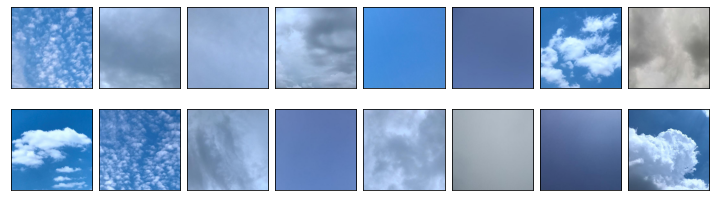

In [12]:
fig = plt.figure(figsize=(16, 16))
fig.set_figwidth(10)
fig.set_figheight(3)

columns = 8
rows = 2

##fig.suptitle('Muestra del conjunto de entrenamiento GCD', fontsize=14)

for i in range(1, 17):
    img = images[i-1]
    fig.add_subplot(rows, columns, i)
    plt.imshow(img.numpy().transpose(1,2,0)) 
    plt.xticks([])
    plt.yticks([])
    
plt.subplots_adjust(left=0.2,
                    bottom=0.2, 
                    right=1, 
                    top=0.8, 
                    wspace=0.2, 
                    hspace=0.4)

fig.tight_layout()
fig.savefig('assets/sample_gcd.png')
plt.show()

# 3. Tecnicas de construccion de la matriz de adyacencia

In [13]:
%cd ..

/home/ltorres/leo/Cloud-Classification/cloud_classification


In [14]:
from src.modules.conv_modules import CNNExtractor
from src.dataset import GCD

In [15]:
dataset = GCD(sample_paths, 256)

train_loader = torch.utils.data.DataLoader(
        dataset,
        batch_size=16,
        num_workers=6,
        shuffle=False,
    )

In [16]:
batch = next(iter(train_loader))

In [17]:
cnn = CNNExtractor(feature_extraction=False)
cnn.eval()
print("initiated model")

initiated model


In [18]:
features = cnn(batch['images'])
features.shape

torch.Size([16, 2048])

- De la red convolucional se obtiene un vector de 2048 dimensiones por cada imagen

---

In [19]:
def normalize_features(dfs):
    norm = dfs.norm(dim=1).view(-1,1)
    return dfs/norm

## 3.1. Similitud de Coseno

In [25]:
def build_graph_cosine_similarity(deep_features, threshold):
    """
    returns a dgl graph built with an edge index calculated from the deep features 
    using cosine similarity
    """
    
    with torch.no_grad():
        batch_nodes = normalize_features(deep_features)

        sim_matrix = batch_nodes @ batch_nodes.T
        adj_matrix = torch.where(sim_matrix >= threshold, 1, 0)
 
    return adj_matrix

In [26]:
cos_sim_adj = build_graph_cosine_similarity(features, threshold=0.6)

In [28]:
cos_sim_adj

tensor([[1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 1, 0, 1, 0, 0, 1],
        [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
        [1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
        [1, 1, 1, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 0, 0, 1],
        [1, 0, 0, 1, 0, 0, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
        [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
        [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 1],
        [1, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0, 0, 0, 1, 1]])

In [27]:
get_matrix_density(cos_sim_adj)

0.4140625

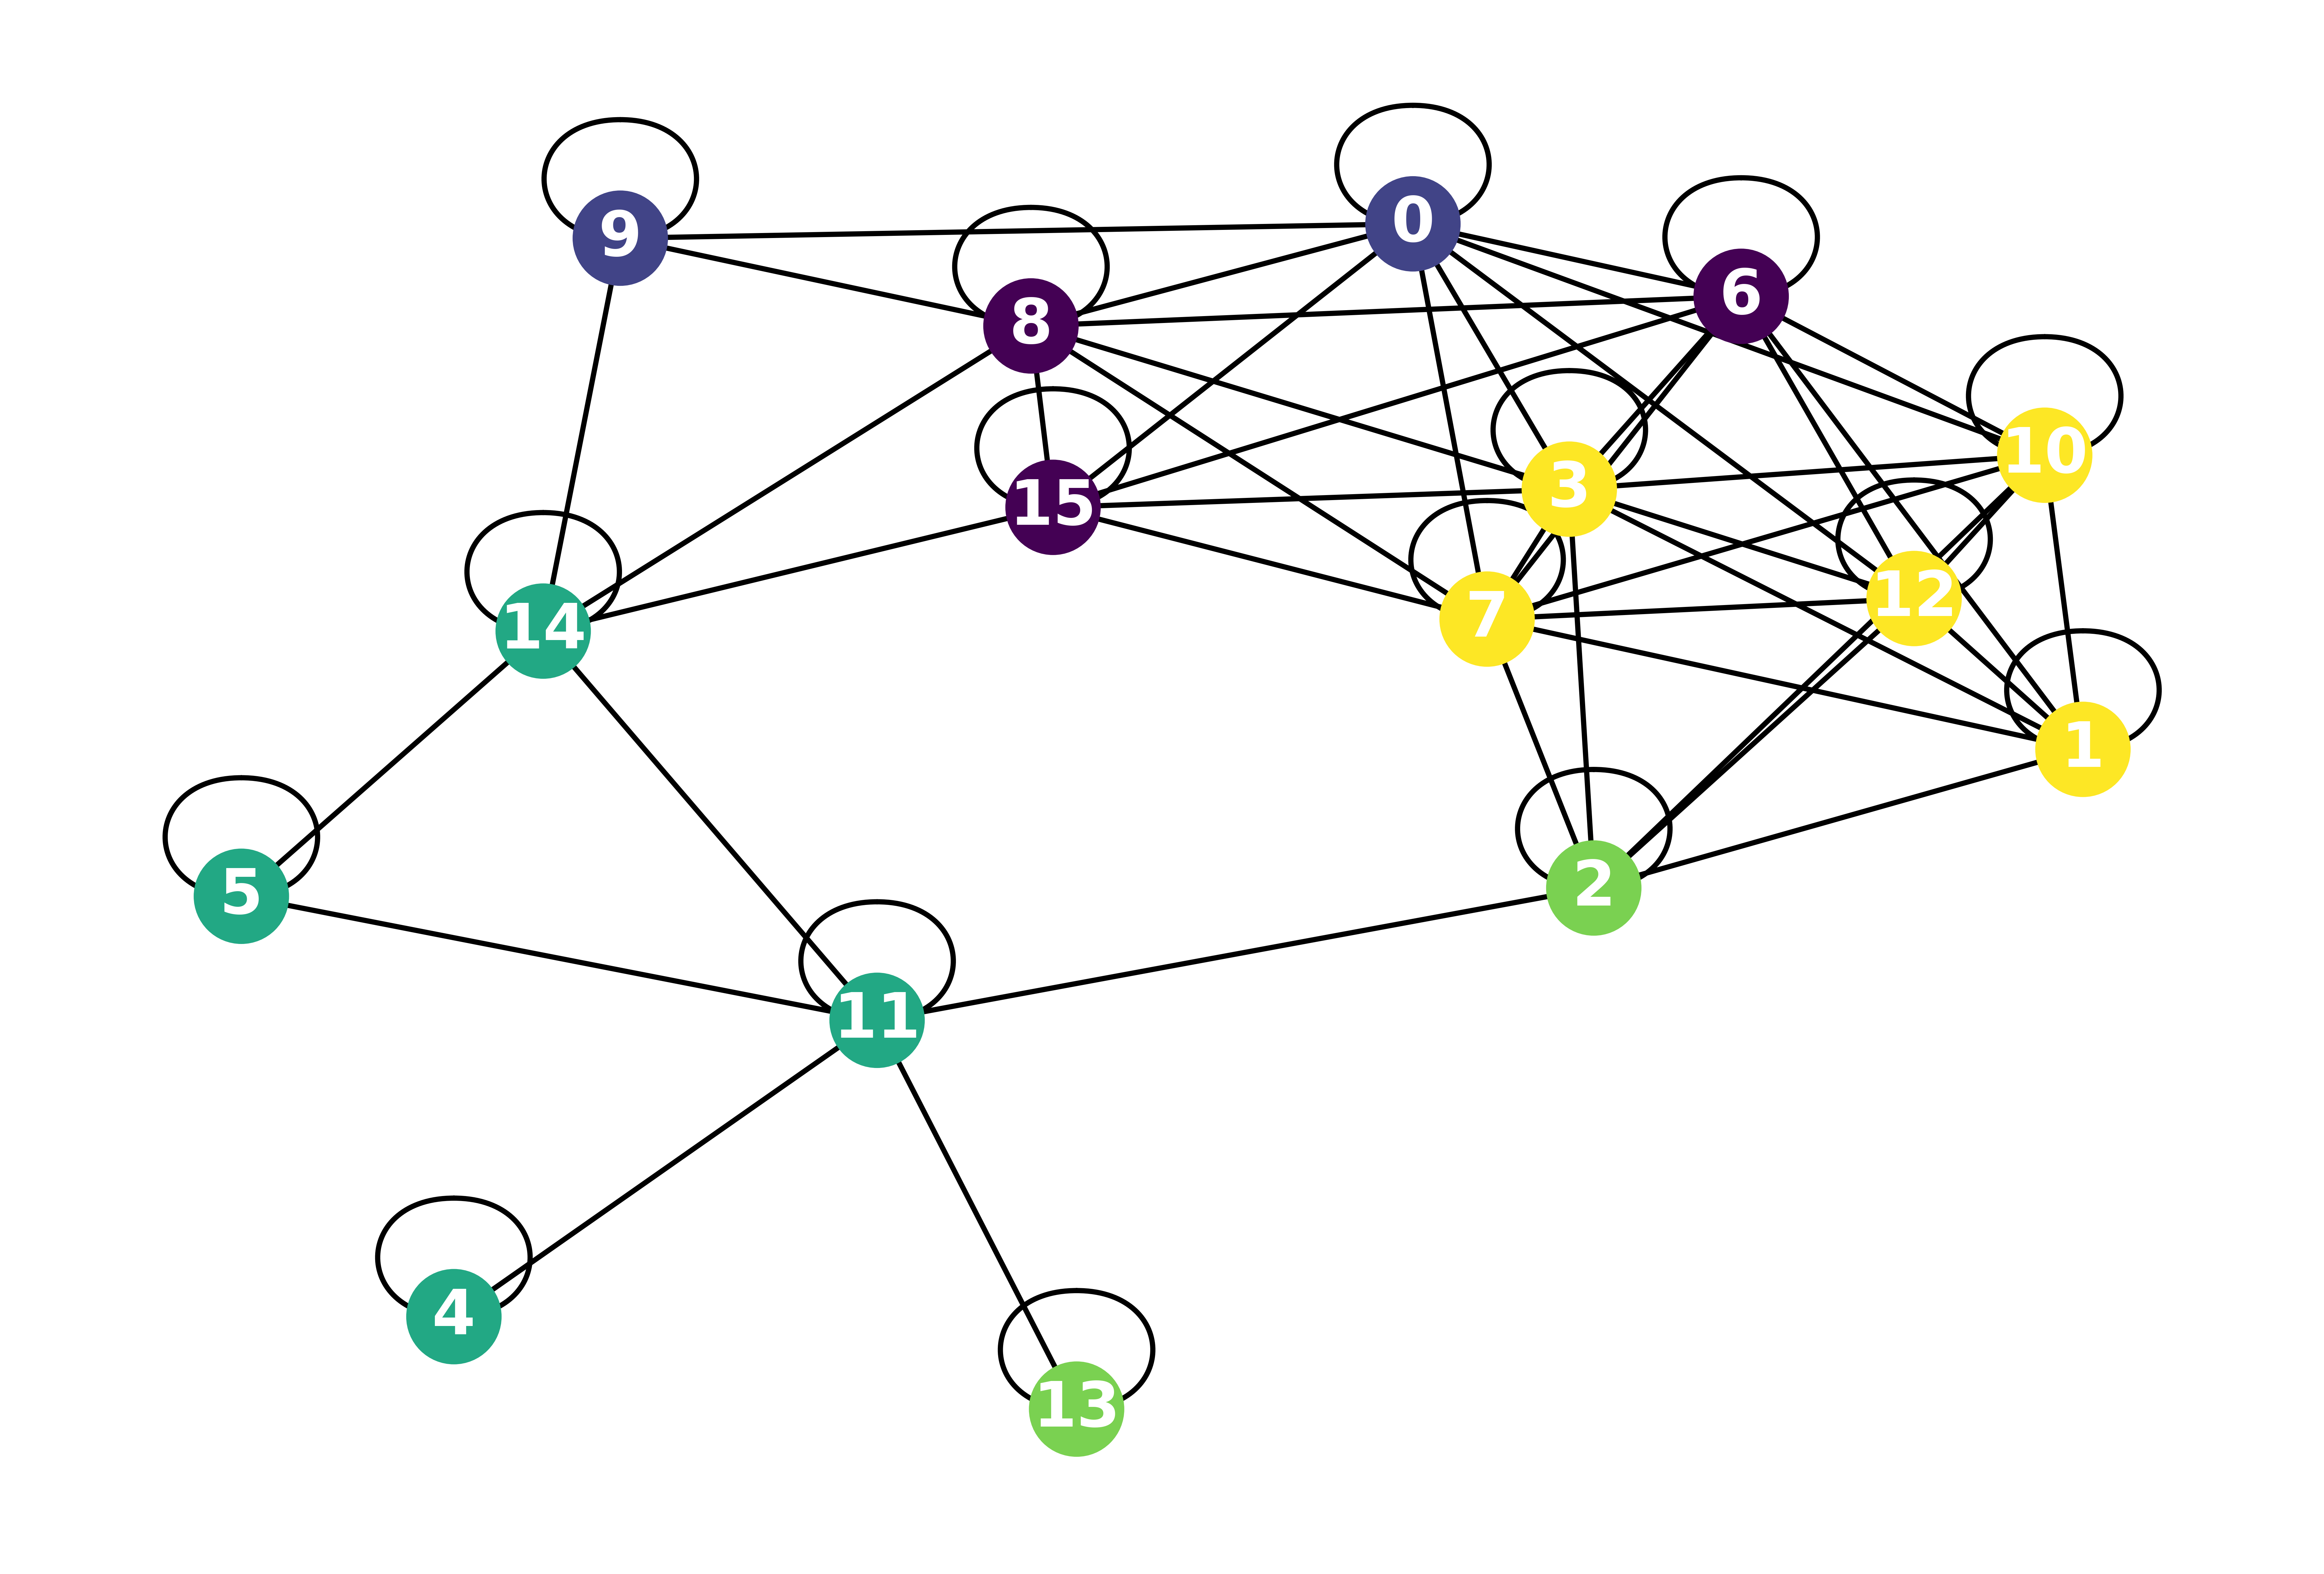

In [24]:
G = nx.from_numpy_matrix(cos_sim_adj.numpy(), create_using=nx.Graph)

plt.figure(1,figsize=(6,4), dpi=1200) 
nx.draw(G, nx.kamada_kawai_layout(G), with_labels=True, node_color=batch['targets'].numpy(), font_color="white", font_weight="bold")
plt.savefig('./notebooks/assets/cos_sim_graph.png')
plt.show()

## 3.2. Correlacion de Pearson

In [25]:
def build_graph_pearson_correlation(dfs, threshold):
    """
    returns a dgl graph built with an edge index calculated from the deep features 
    using pearson correlation
    """
    with torch.no_grad():
        corr_matrix = torch.corrcoef(dfs)
        adj_matrix = torch.where(corr_matrix >= threshold, 1, 0)
        row, col = torch.where(adj_matrix==1)
    
    return adj_matrix

In [26]:
pearson_corr_adj = build_graph_pearson_correlation(features, threshold=0.5)

In [27]:
pearson_corr_adj.numpy()

array([[1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 1, 1, 0, 0, 0],
       [0, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 1, 1],
       [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
       [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 1, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
       [1, 1, 1, 1, 0, 0, 1, 1, 0, 0, 1, 0, 1, 0, 0, 0],
       [0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0],
       [0, 0, 0, 0, 0, 1, 0, 0, 1, 1, 0, 1, 0, 0, 1, 0],
       [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]])

In [28]:
get_matrix_density(pearson_corr_adj)

0.296875

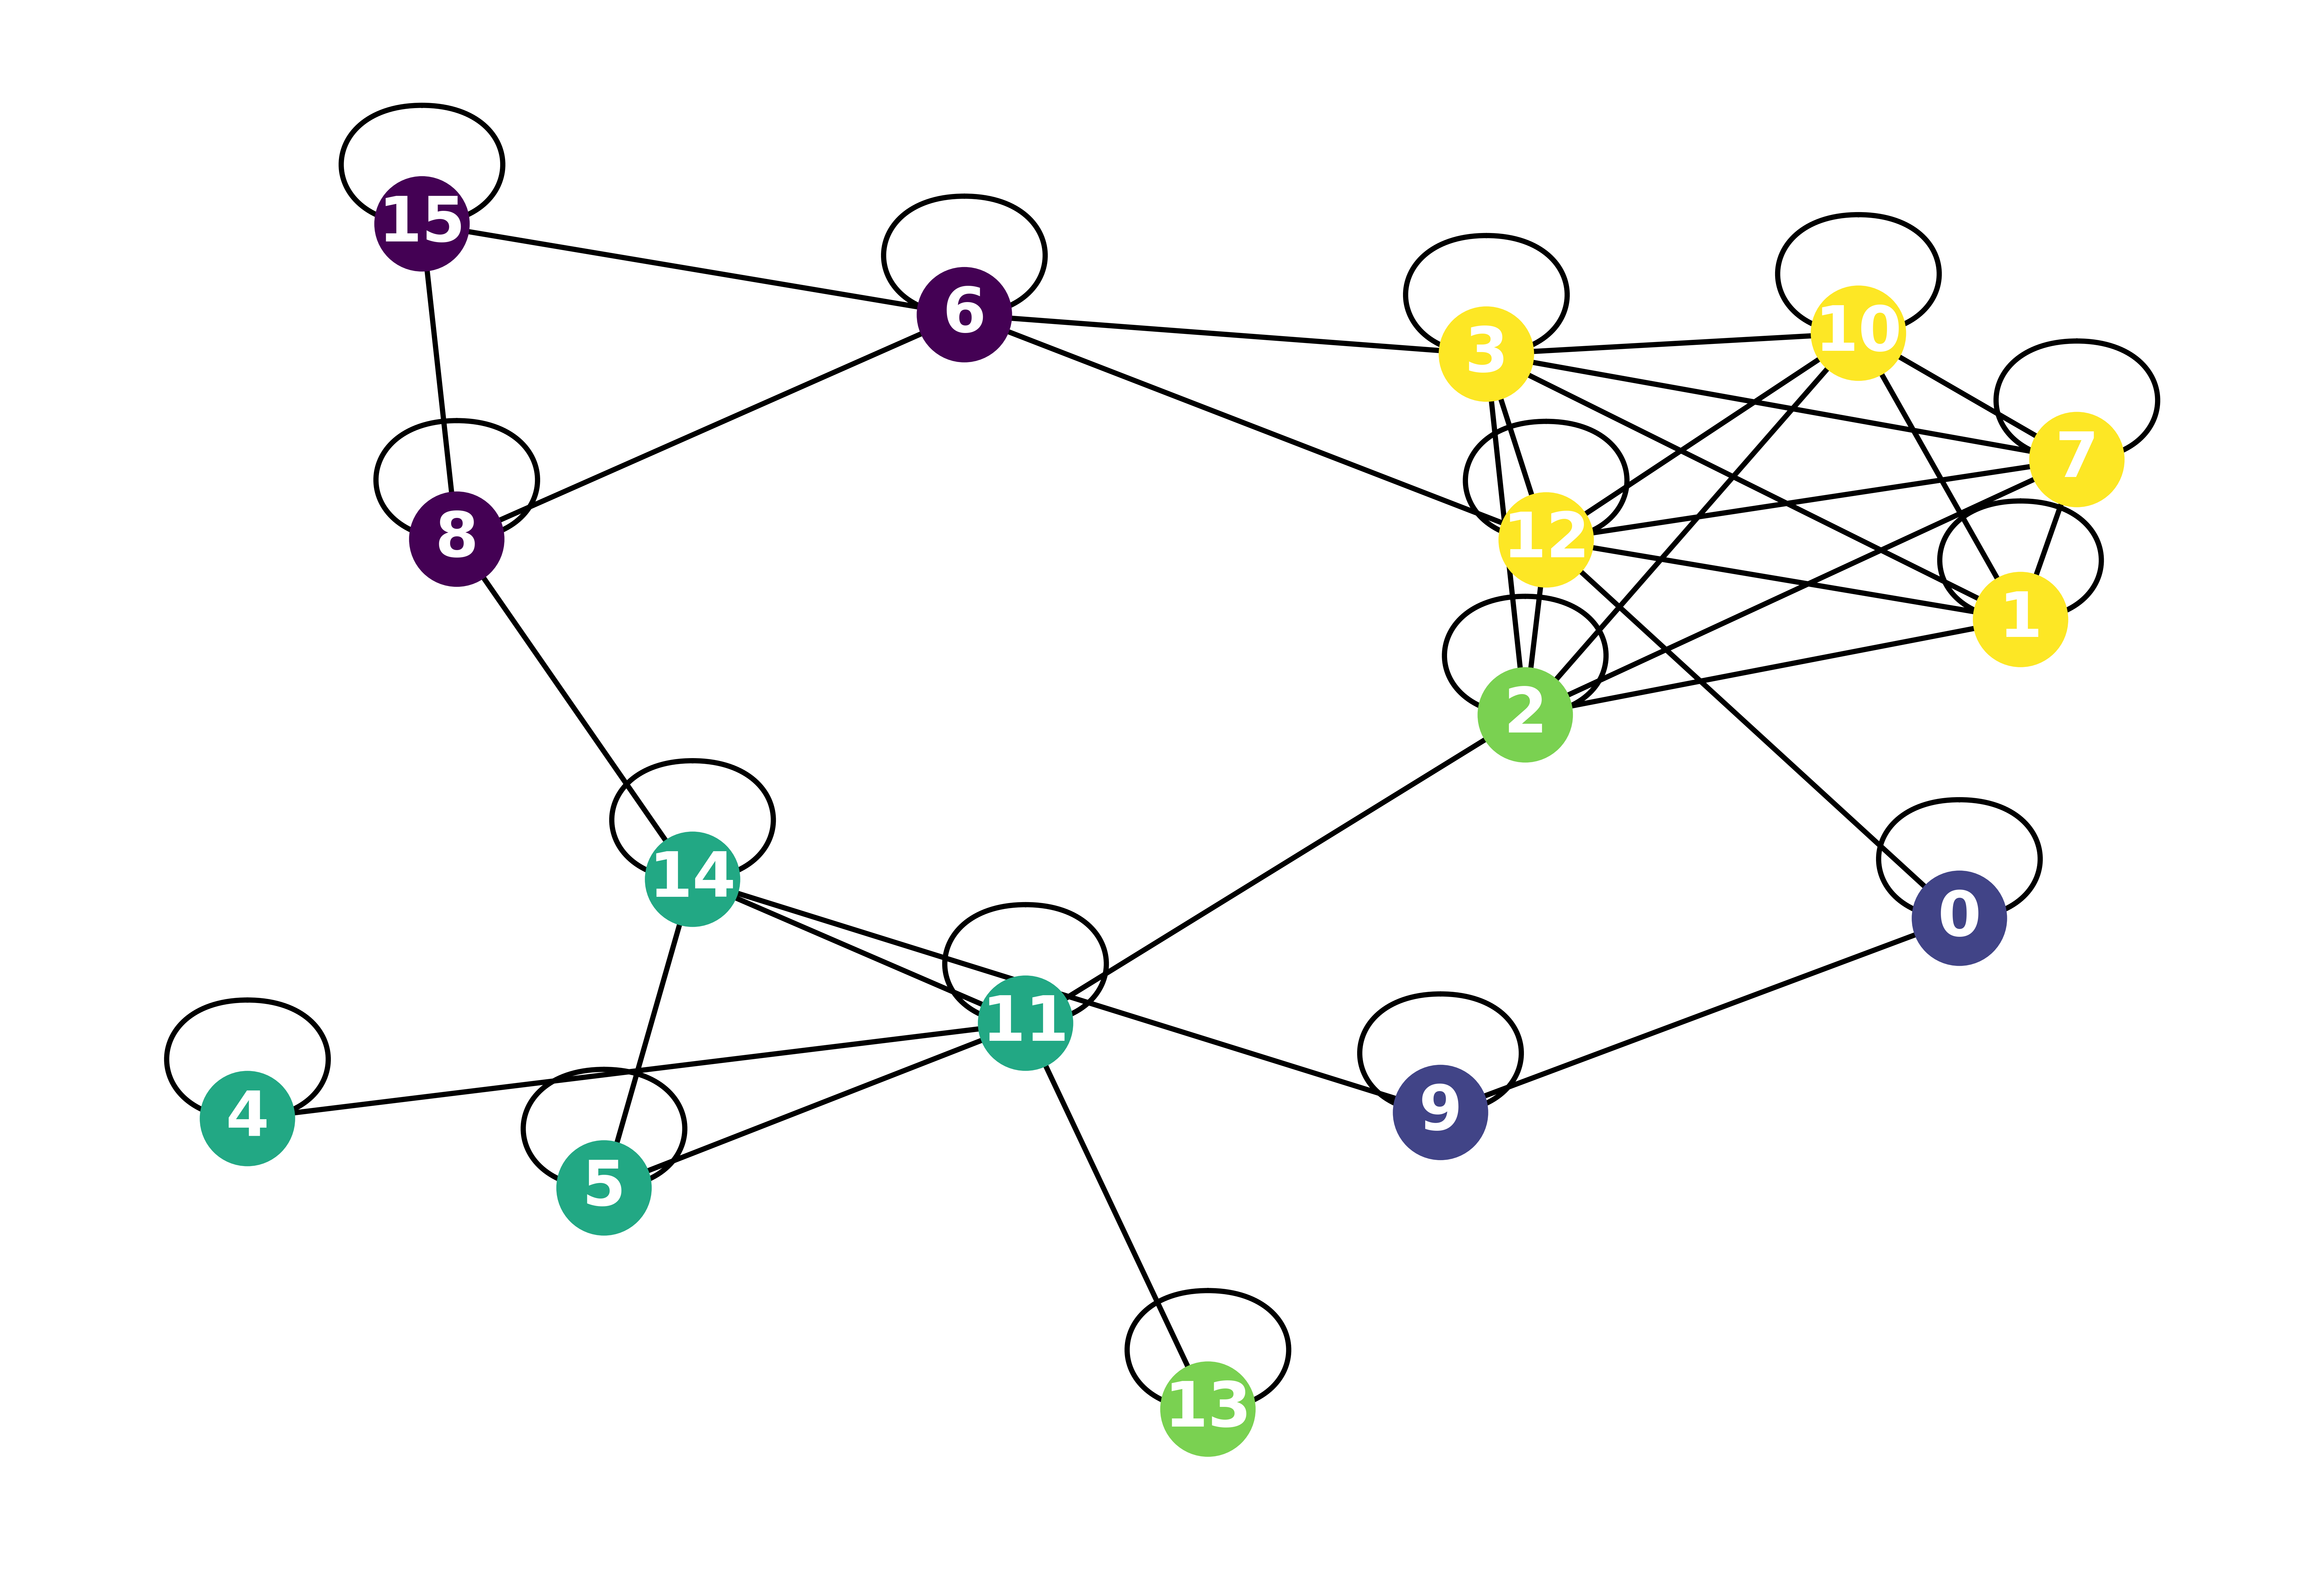

In [29]:
G = nx.from_numpy_matrix(pearson_corr_adj.numpy(), create_using=nx.Graph)

plt.figure(1,figsize=(6,4), dpi=1200)
nx.draw(G, nx.kamada_kawai_layout(G), with_labels=True, node_color=batch['targets'].numpy(), font_color="white", font_weight="bold")
plt.savefig('./notebooks/assets/pearson_corr_graph.png')
plt.show()

## 3.3. Distancia Euclidiana

In [30]:
def pairwise_distance(x):
    
    x_inner = -2*torch.matmul(x, x.T)
    x_square = torch.sum(torch.mul(x, x), dim=-1, keepdim=True)
    
    return torch.sqrt(x_square + x_inner + x_square.T) #SQRT((x - x.T)^2 = X^2 -2XX.T + X.T^2)

In [31]:
def build_graph_l2_distance(features, k):
    with torch.no_grad():
        distances = pairwise_distance(features)
        
        batch_size = features.shape[0]
        
        _, src_idx = torch.topk(-distances, k=k)
        
        src_idx = src_idx.flatten()
        dst_idx = torch.arange(0, batch_size).repeat_interleave(k)
        
        adj_mat = torch.zeros(batch_size, batch_size).long()
        adj_mat[src_idx, dst_idx] = 1
        
        return adj_mat 

In [32]:
l2_adj = build_graph_l2_distance(features, 5)

In [33]:
l2_adj

tensor([[1, 0, 0, 0, 0, 0, 1, 0, 0, 1, 0, 0, 0, 0, 0, 0],
        [0, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 1, 1, 1, 1, 1, 0, 0, 0, 0, 1, 1, 0, 1, 0, 0],
        [1, 1, 0, 1, 0, 0, 1, 1, 1, 0, 1, 0, 1, 1, 0, 1],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0],
        [0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0, 0, 1],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1],
        [1, 0, 0, 0, 0, 0, 0, 0, 0, 1, 0, 0, 0, 0, 1, 0],
        [1, 1, 1, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
        [1, 1, 0, 1, 0, 0, 0, 1, 0, 0, 1, 0, 1, 0, 0, 0],
        [0, 0, 1, 0, 1, 1, 0, 0, 0, 1, 0, 1, 0, 1, 1, 0],
        [0, 0, 0, 0, 0, 0, 0, 0, 1, 1, 0, 0, 0, 0, 1, 0],
        [0, 0, 0, 0, 0, 0, 1, 0, 1, 0, 0, 0, 0, 0, 0, 1]])

In [34]:
get_matrix_density(l2_adj)

0.3125

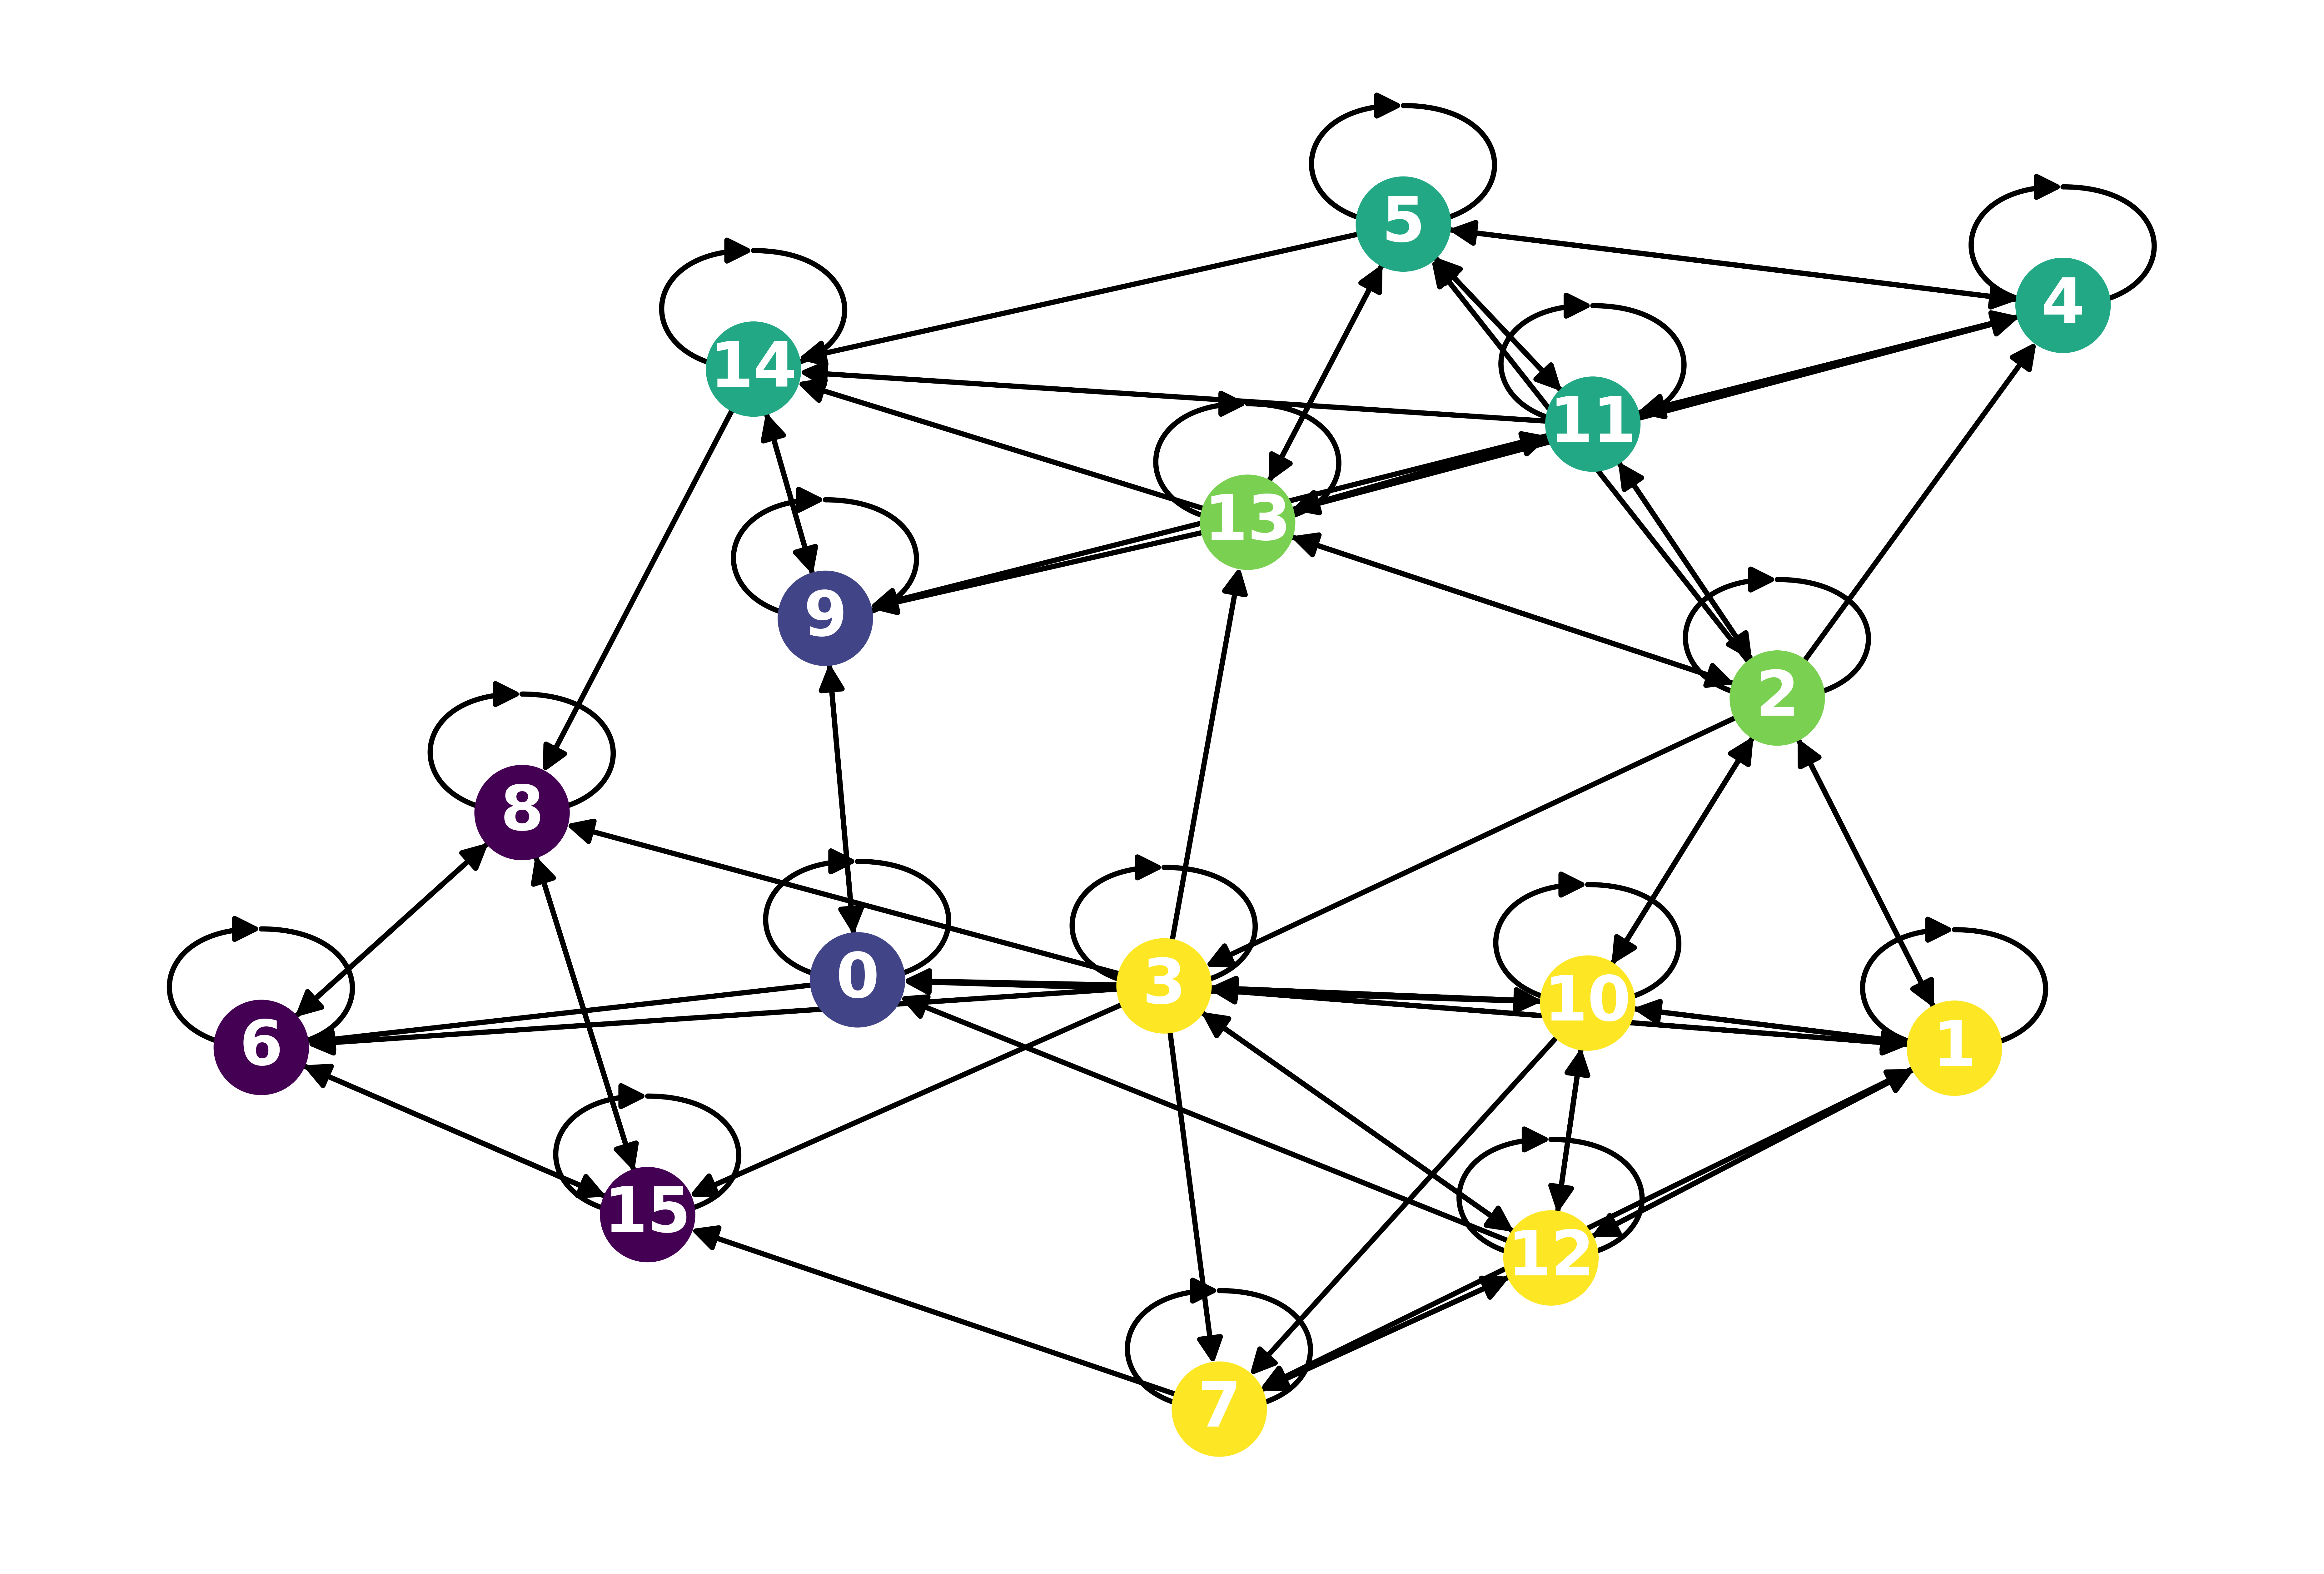

In [35]:
G = nx.from_numpy_matrix(l2_adj.numpy(), create_using=nx.DiGraph)

plt.figure(1,figsize=(6,4), dpi=1200)
nx.draw(G, nx.kamada_kawai_layout(G), with_labels=True, node_color=batch['targets'].numpy(), font_color="white", font_weight="bold")
plt.savefig('./notebooks/assets/l2_distance_graph.png')
plt.show()

# 4. Aristas comunes

In [41]:
def get_nedges(tensor):
    with torch.no_grad():
        density = tensor.sum().item()
    return density

In [38]:
cos_x_pearson = cos_sim_adj * pearson_corr_adj

cos_x_l2 = cos_sim_adj * l2_adj

pearson_x_l2 = pearson_corr_adj * l2_adj

cos_x_pearson_x_l2 = cos_sim_adj * pearson_corr_adj * l2_adj

In [44]:
cos_nedges = get_nedges(cos_sim_adj)
pearson_nedges = get_nedges(pearson_corr_adj)
l2_nedges = get_nedges(l2_adj)

print("Cos",  cos_nedges)
print("Pearson",  pearson_nedges)
print("L2", l2_nedges)

Cos 106
Pearson 76
L2 80


In [46]:
center_nedges = get_nedges(cos_x_pearson_x_l2)
center_nedges

61

In [48]:
###Coseno x Pearson
get_nedges(cos_x_pearson) - center_nedges

15

In [49]:
###Coseno x L2
get_nedges(cos_x_l2) - center_nedges

6

In [50]:
### Only Coseno = 
cos_nedges - center_nedges - (get_nedges(cos_x_pearson) - center_nedges) - (get_nedges(cos_x_l2) - center_nedges)

24

In [52]:
### Pearson x L2
get_nedges(pearson_x_l2) - center_nedges

0

In [53]:
### Only L2
l2_nedges - center_nedges - (get_nedges(cos_x_l2) - center_nedges) - (get_nedges(pearson_x_l2) - center_nedges)

13